<h1>Regression</h1>

In [1]:
import csv
import numpy as np
import pandas as pd
import re
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

<h2>Laden der Daten</h2>

In [2]:
df_de = pd.read_csv("/Users/tobias/Dev/FOM/Master_Thesis/data/Sentiment_Analysis/Dataset_DE_Bert_Vader.csv", sep=";",
                parse_dates=["created_at"])

#Change the date field
df_de["Date"] = pd.to_datetime(df_de.created_at).apply(lambda x: x.date())

#Change the values of sentiment bert field and add a new field for a numeric value sentiment value 
df_de["sentiment_bert"] = df_de["sentiment_bert"].replace(["neutral", "negative", "positive"], ["NEU", "NEG", "POS"])
df_de["sentiment_bert_value"] = df_de["sentiment_bert"].replace({"NEU": 0, "NEG": -1, "POS": 1})

#Create a new field for a numeric sentiment value
df_de["sentiment_vader_value"] = [1 if i >= 0.05 else -1 if i <= -0.05 else 0 for i in df_de["sentiment_vader"]]

#Create a df for adding the year and week to the df
df_de_week_year = pd.DataFrame([(i.isocalendar().week, i.isocalendar().year) for i in df_de["Date"]],
                               columns=["Week", "Year"])
#Adding the week and year information to the df
df_de[["Week", "Year"]] = df_de_week_year[["Week", "Year"]]

In [3]:
df_en = pd.read_csv("/Users/tobias/Dev/FOM/Master_Thesis/data/Sentiment_Analysis/Dataset_Bert_Vader.csv", sep=";",
                parse_dates=["created_at"])

#Change the date field
df_en["Date"] = pd.to_datetime(df_en.created_at).apply(lambda x: x.date())

#Add a new column for a numeric sentiment bert value
df_en["sentiment_bert_value"] = df_en["sentiment_bert"].replace({"NEU": 0, "NEG": -1, "POS": 1})

#Add a new column for a numeric sentiment vader value
df_en["sentiment_vader_value"] = [1 if i >= 0.05 else -1 if i <= -0.05 else 0 for i in df_en["sentiment_vader"]]

#Create a df for adding the year and week to the df
df_en_week_year = pd.DataFrame([(i.isocalendar().week, i.isocalendar().year) for i in df_en["Date"]],
                               columns=["Week", "Year"])
#Adding the week and year information to the df
df_en[["Week", "Year"]] = df_en_week_year[["Week", "Year"]]

In [4]:
#Combine the different DFs
df = pd.concat([df_en, df_de]).reset_index(drop=True)

In [5]:
#Change the values from sentiment_bert_value from text to a num value
df["sentiment_bert_value"] = df["sentiment_bert"].replace({"NEU": 0, "NEG": -1, "POS": 1})

#Create a df for adding the year and week to the df
df_week_year = pd.DataFrame([(i.isocalendar().week, i.isocalendar().year) for i in df["Date"]], columns=["Week", "Year"])
#Adding the week and year information to the df
df[["Week", "Year"]] = df_week_year[["Week", "Year"]]

In [6]:
df_wdi = pd.read_csv("/Users/tobias/Dev/FOM/Master_Thesis/data/WDI.HM-2.csv", parse_dates=["Date"])
df_wdi = df_wdi.rename(columns={"Adj Close": "Adj_Close"})

In [7]:
df_stoxx = pd.read_csv("/Users/tobias/Dev/FOM/Master_Thesis/data/^STOXX50E.csv", parse_dates=["Date"])
df_stoxx = df_stoxx.rename(columns={"Adj Close": "Adj_Close"})

In [8]:
df_visa = pd.read_csv("/Users/tobias/Dev/FOM/Master_Thesis/data/V.csv", parse_dates=["Date"])
df_visa = df_visa.rename(columns={"Adj Close": "Adj_Close"})

In [9]:
df_ma = pd.read_csv("/Users/tobias/Dev/FOM/Master_Thesis/data/MA.csv", parse_dates=["Date"])
df_ma = df_ma.rename(columns={"Adj Close": "Adj_Close"})

<h2>Vorverarbeitung der Daten</h2>

In [10]:
#Berechnung der Returns für Log
df_wdi["returns"] = np.log(df_wdi.Close.pct_change() + 1)
df_wdi["returns_2"] = df_wdi.Close.pct_change() + 1
df_wdi["returns_3"] = df_wdi.Close.pct_change()
df_wdi["returns_5"] = df_wdi.Close.pct_change(periods=5) + 1

#Change Date für df_wdi & df
df_wdi["Date"] = pd.to_datetime(df_wdi.Date).apply(lambda x: x.date())
df_stoxx["Date"] = pd.to_datetime(df_stoxx.Date).apply(lambda x: x.date())
df_visa["Date"] = pd.to_datetime(df_visa.Date).apply(lambda x: x.date())
df_ma["Date"] = pd.to_datetime(df_ma.Date).apply(lambda x: x.date())


In [11]:
#Berechnung der Lags
def lagit(df, lags, shifter, drop=False):
    names = []
    for each in shifter:
        for i in range(1, lags+1):
            df["Lag_"+each+"_"+str(i)] = df[each].shift(i)
            names.append("Lag_"+each+"_"+str(i))
    if drop:
        df.dropna(inplace=True)
        df = df.reset_index(drop=True)
    return names, df

In [12]:
def log_fkt(df, column):
    df[column] = np.log(df[column]).replace([np.inf, -np.inf], 0)
    
    return df

In [13]:
def create_finance_df(df):
    #Create df for returning
    df_week = pd.DataFrame(columns=["Date", "Week", "Year", "Adj_Close"])
    
    #Start Week
    week = 5
    volume = 0
    
    #To loop through all lines in df
    for each in range(len(df)):
        #Get the date
        each_date = df["Date"][each]
        adj_close = df["Adj_Close"][each]
        
        #Get the Volume of all transactions in a week
        volume = volume + df["Volume"][each]

        #Check if the date is the last date
        if df["Date"][each] == datetime.date(2020,7,31):
            #Get Week Number, start and end day
            week = each_date.isocalendar().week
            year = each_date.isocalendar().year
            end_day = df["Date"].iloc[-1]
            
            #Add data to df
            new_row = pd.DataFrame([[each_date, week, year, adj_close, volume]],
                                   columns=["Date", "Week", "Year", "Adj_Close", "Volume"])
            df_week = pd.concat([df_week, new_row], ignore_index=True)
        else:
            #Get the next week number for checking
            next_week = df["Date"][each+1].isocalendar().week

            #Check if the next day is in another week 
            if each_date.isocalendar().week != next_week:
                #Get week number, year and last date
                week = each_date.isocalendar().week
                year = each_date.isocalendar().year
                end_day = each_date
                
                #Add data to df
                new_row = pd.DataFrame([[each_date, week, year, adj_close, volume]],
                                       columns=["Date", "Week", "Year", "Adj_Close", "Volume"])
                df_week = pd.concat([df_week, new_row], ignore_index=True)
                
                #Set Volume back to 0
                volume = 0
    
    #Add the yield from one week to another
    df_week["returns_week"] = df_week.Adj_Close.pct_change()+1
    #df_week["returns_week_log"] = pd.Series(np.log(np.float64(df_week.Adj_Close))).pct_change()
    

    
    #Return the new DF
    return df_week

In [14]:
def concat_finance_df(df_wdi = df_wdi, df_stoxx = df_stoxx, df_ma = df_ma, df_v = df_visa):
    
    #Create week dfs for all financial dfs
    df_wdi_week = create_finance_df(df_wdi)
    df_stoxx_week = create_finance_df(df_stoxx)
    df_ma_week = create_finance_df(df_ma)
    df_v_week = create_finance_df(df_v)
    
    #combine all dfs
    df_week = pd.concat([df_wdi_week, df_stoxx_week.rename(columns={"returns_week": "returns_stoxx"})["returns_stoxx"]],
                        axis=1)
    df_week = pd.concat([df_week, df_ma_week.rename(columns={"returns_week": "returns_ma"})["returns_ma"]], axis=1)
    df_week = pd.concat([df_week, df_v_week.rename(columns={"returns_week": "returns_visa"})["returns_visa"]], axis=1)
    return df_week

In [15]:
def create_final_df(df_week, df, meta_data = False):
    
    #If meta data like Retweets should be used, this will calculate it.
    if meta_data:
        df["sentiment_bert_value"] = df["sentiment_bert_value"] * ((df["retweet_count"] + 1))
        df["sentiment_vader_value"] = df["sentiment_vader_value"] * ((df["retweet_count"] + 1))
    
    df_sum_year_week_bert = pd.DataFrame(df[["Week", "Year", "sentiment_bert_value"]].
                                    groupby(by=["Year", "Week"]).sum()).reset_index()

    df_sum_year_week_vader = pd.DataFrame(df[["Week", "Year", "sentiment_vader_value"]].
                                    groupby(by=["Year", "Week"]).sum()).reset_index()
    
    df_count_tweets_year_week = pd.DataFrame(df[["Week", "Year", "conversation_id"]].
                                    groupby(by=["Year", "Week"]).
             count()).reset_index().rename(columns={"conversation_id": "count_all_tweets"})
    
    df_week = df_week.merge(df_sum_year_week_bert)
    df_week = df_week.merge(df_sum_year_week_vader)
    df_week = df_week.merge(df_count_tweets_year_week)

    
    return df_week

<h2>Lineare Regression mit Statsmodels</h2>

In [16]:
def regression_train_test(df, regressor, output):

    train, test = train_test_split(df, shuffle=False, test_size=0.05, random_state=0)
    
    train_x = train[regressor]
    train_y = train[output]
    
    test_x = test[regressor]
    test_y = test[output]
    
    train_x = sm.add_constant(train_x)
    test_x = sm.add_constant(test_x)
    
    model = sm.OLS(train_y, train_x).fit()
    
    predictions = model.predict(test_x)
    
    #predict values from training
    train_pred = model.predict(train_x)
    
    print_model = model.summary()
    
    #print(predictions)
    print(print_model)
    
    #Calculate the scuared mean squared error on the predicted values based on the real values. 
    print("Mean Squared Error: ", np.sqrt(mean_squared_error(test_y, predictions)))
    
    #Calulate the r2 values based on the prediccted and the real values, 
    print("R2: ", r2_score(test_y, predictions))
    
    return model, predictions, test, test_y, train, train_pred

In [17]:
def regression(df, regressor, output):
    
    x = df[regressor]
    y = df[output]
    
    x = sm.add_constant(x)

    model = sm.OLS(y,x).fit()
    
    predictions = model.predict(x)
    
    pritn_model = model.summary()
    
    print(pritn_model)
    
    return predictions, model

In [18]:
def create_df(df, df_wdi = df_wdi):
    df_sentiment = sup_df_for_calculations(df)
    df_wdi_sentiment = df_wdi.merge(df_sentiment.rename(columns={"created_at": "Date"}), how="left", on="Date").fillna(0)
    return df_wdi_sentiment

<h2>Plot</h2>

In [19]:
def plot_regression(df, regressor, regressant, prediction):
    plt.figure(figsize=(50,10))
    
    plt.scatter(df[regressor], df[regressant], color="blue")
    plt.plot(df[regressor], prediction, color="red")
    
    plt.show()

<h2>Ausführung</h2>

<h3>Regression auf Wochenbasis</h3>

In [634]:
regressor = ["dif_sentiment_bert_value"]
#regressor = ["dif_sentiment_vader_value"]
#regressor = ["sentiment_bert_value"]

further_regressor = ["returns_week", "returns_stoxx", "returns_ma", "returns_visa", "Volume", "count_all_tweets"]

regressand = ["returns_week"]

lag_num = 5
lagnames = []
lag = False

df_twitter = df.copy()

df_week = concat_finance_df()
df_week_reg = create_final_df(df_week, df_twitter)

df_week_reg["dif_sentiment_bert_value"] = df_week_reg["sentiment_bert_value"].diff()
df_week_reg["dif_sentiment_vader_value"] = df_week_reg["sentiment_vader_value"].diff()
df_week_reg["Lag_returns_week"] = df_week_reg["returns_week"].shift(1)

df_week_reg["returns_week_log"] = np.log(df_week_reg["returns_week"])


if lag:
    lags, df_week_reg = lagit(df_week_reg, lag_num, regressor)
    lagnames.extend(lags)

    lags, df_week_reg = lagit(df_week_reg, 1, further_regressor, True)
    lagnames.extend(lags)
else:
    lagnames = ["dif_sentiment_bert_value", "returns_stoxx", "returns_ma", "returns_visa", "Volume", "count_all_tweets"]

    lagnames = ["returns_stoxx"]
    #lagnames = ["sentiment_bert_value", "returns_stoxx", "returns_ma", "returns_visa", "Volume", "count_all_tweets"]
    #lagnames = ["dif_sentiment_vader_value", "returns_stoxx", "returns_ma", "returns_visa", "Volume", "count_all_tweets"]
    df_week_reg.dropna(inplace=True)
    df_week_reg = df_week_reg.reset_index(drop=True)
        
reg_predictions, reg_model = regression(df_week_reg, lagnames, regressand)

                            OLS Regression Results                            
Dep. Variable:           returns_week   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     8.374
Date:                Tue, 11 Oct 2022   Prob (F-statistic):            0.00417
Time:                        20:55:15   Log-Likelihood:                 142.25
No. Observations:                 233   AIC:                            -280.5
Df Residuals:                     231   BIC:                            -273.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1062      0.310      0.343

In [490]:
print(np.var(df_week_reg["returns_week"]))
print(np.var(df_week_reg["returns_week_log"]))

print(np.std(df_week_reg["returns_week"]))
print(np.std(df_week_reg["returns_week_log"]))

0.017893142170442015
0.05017049975137857
0.1337652502350368
0.2239877223228509


In [492]:
np.square(3)

9

In [506]:
test = [42, 44, 43]
test = df_week_reg["returns_week"]
test = reg_predictions
rech = []
for each in test:
    calc = np.square(each - np.mean(test))
    rech.append(calc)
sum(rech)
#print(rech)

10.45392640491249

In [588]:
test = [42.5, 43.5, 43, 43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43]
np.var(test)

0.0125

In [513]:
3**2

9

In [474]:
df_week_reg["returns_week"]-1

0      0.081163
1     -0.127689
2      0.050134
3     -0.140669
4     -0.044415
         ...   
228    1.288732
229   -0.283846
230   -0.152653
231   -0.011662
232   -0.030371
Name: returns_week, Length: 233, dtype: float64

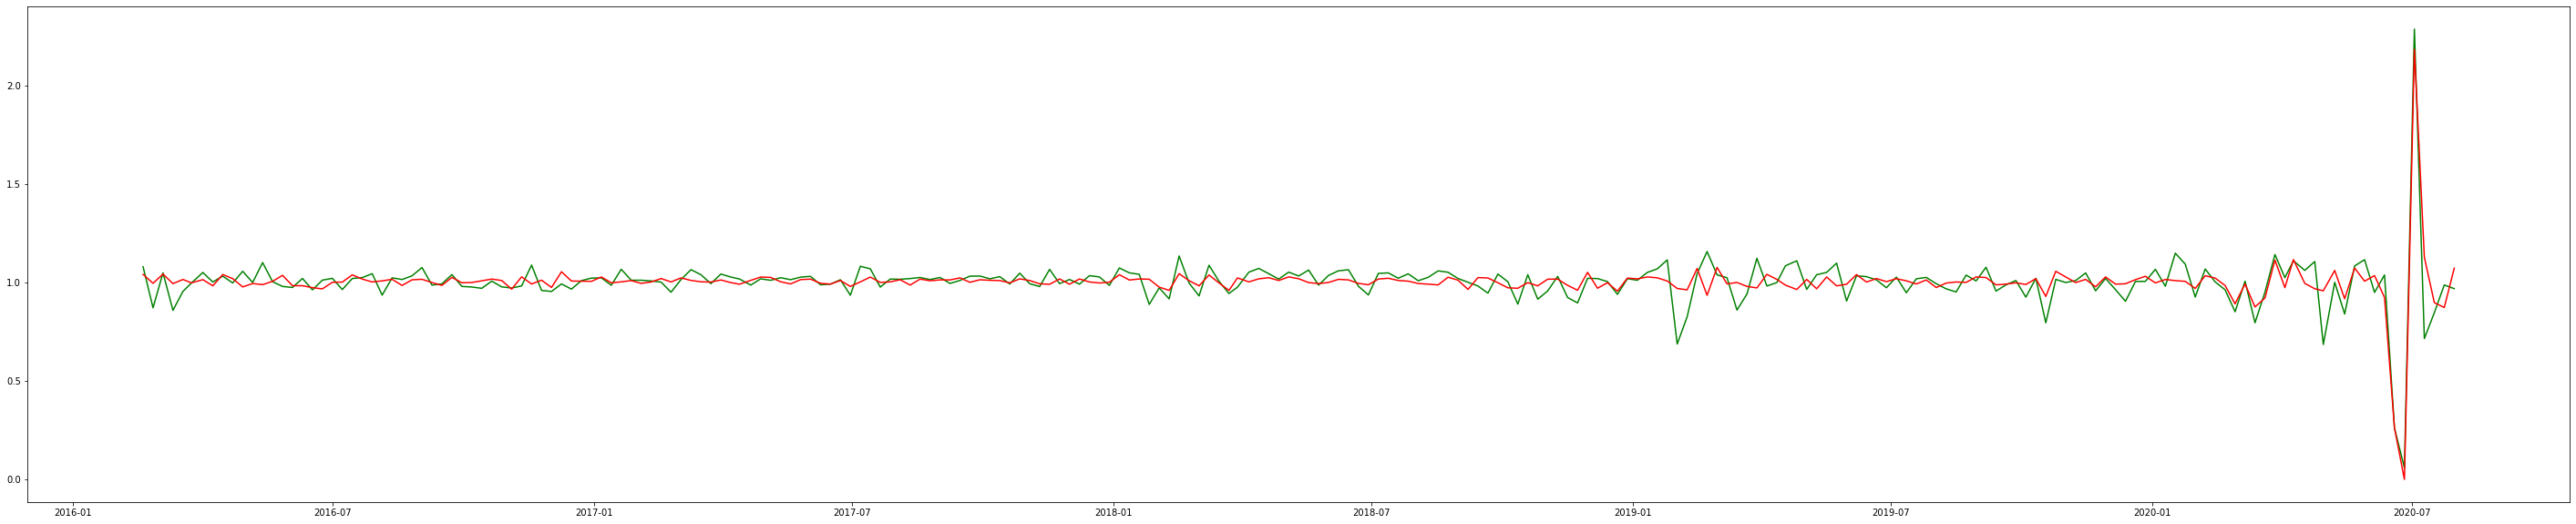

In [399]:
#### This Graph plots the predicted values agains the real values in the time perspektive. 
plt.figure(figsize=(50,10))


plt.plot(df_week_reg["Date"], df_week_reg["returns_week"], color="green")
plt.plot(df_week_reg["Date"], reg_predictions, color="red")

plt.show()

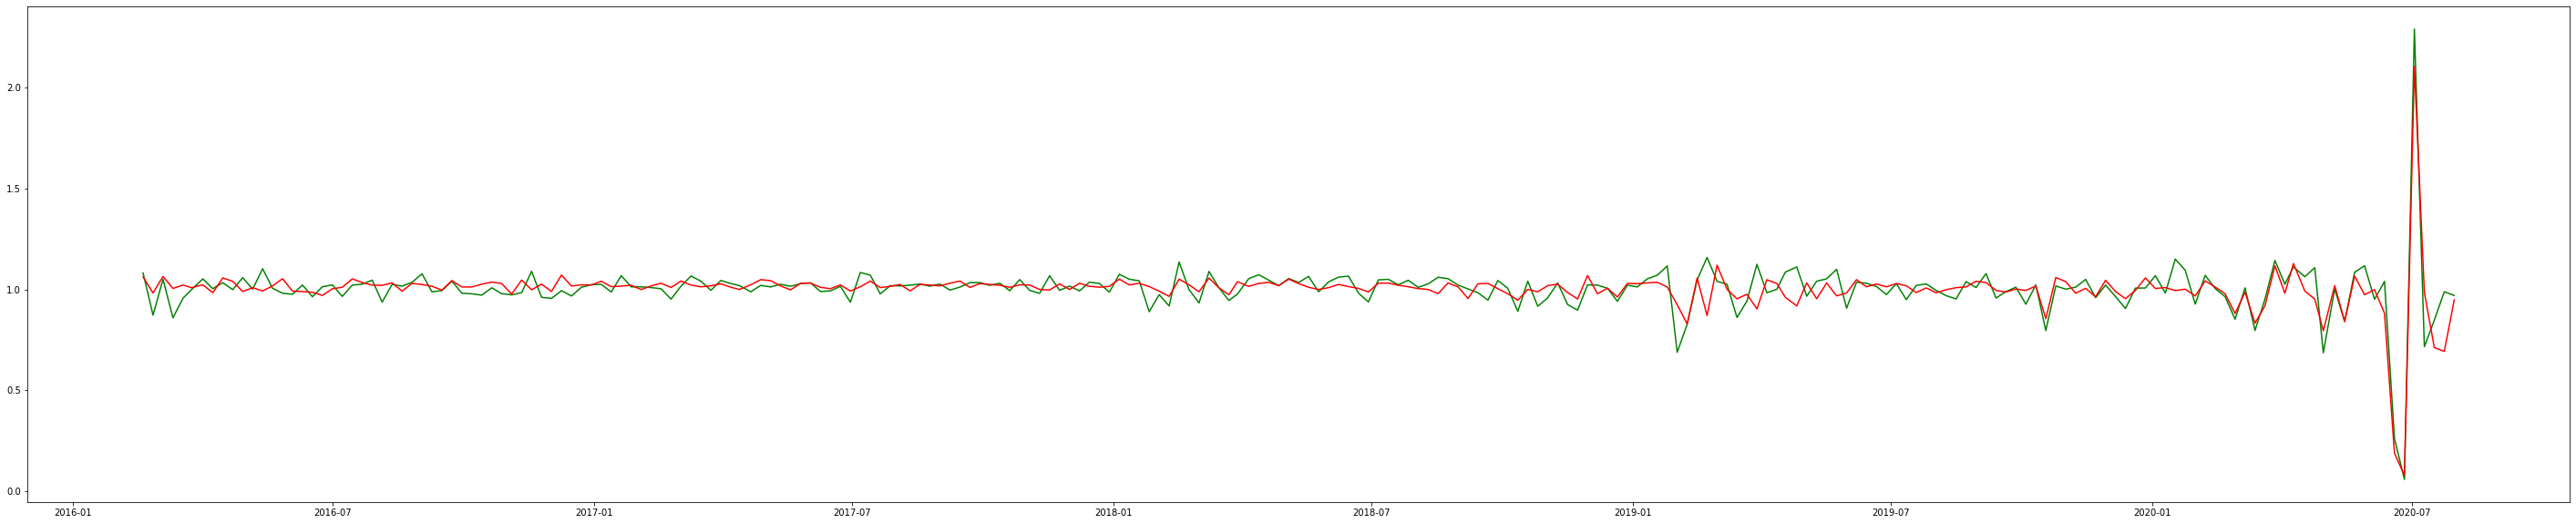

In [403]:
#### This Graph plots the predicted values agains the real values in the time perspektive. 
plt.figure(figsize=(50,10))


plt.plot(df_week_reg["Date"], np.exp(df_week_reg["returns_week_log"]), color="green")
plt.plot(df_week_reg["Date"], np.exp(reg_predictions), color="red")

plt.show()

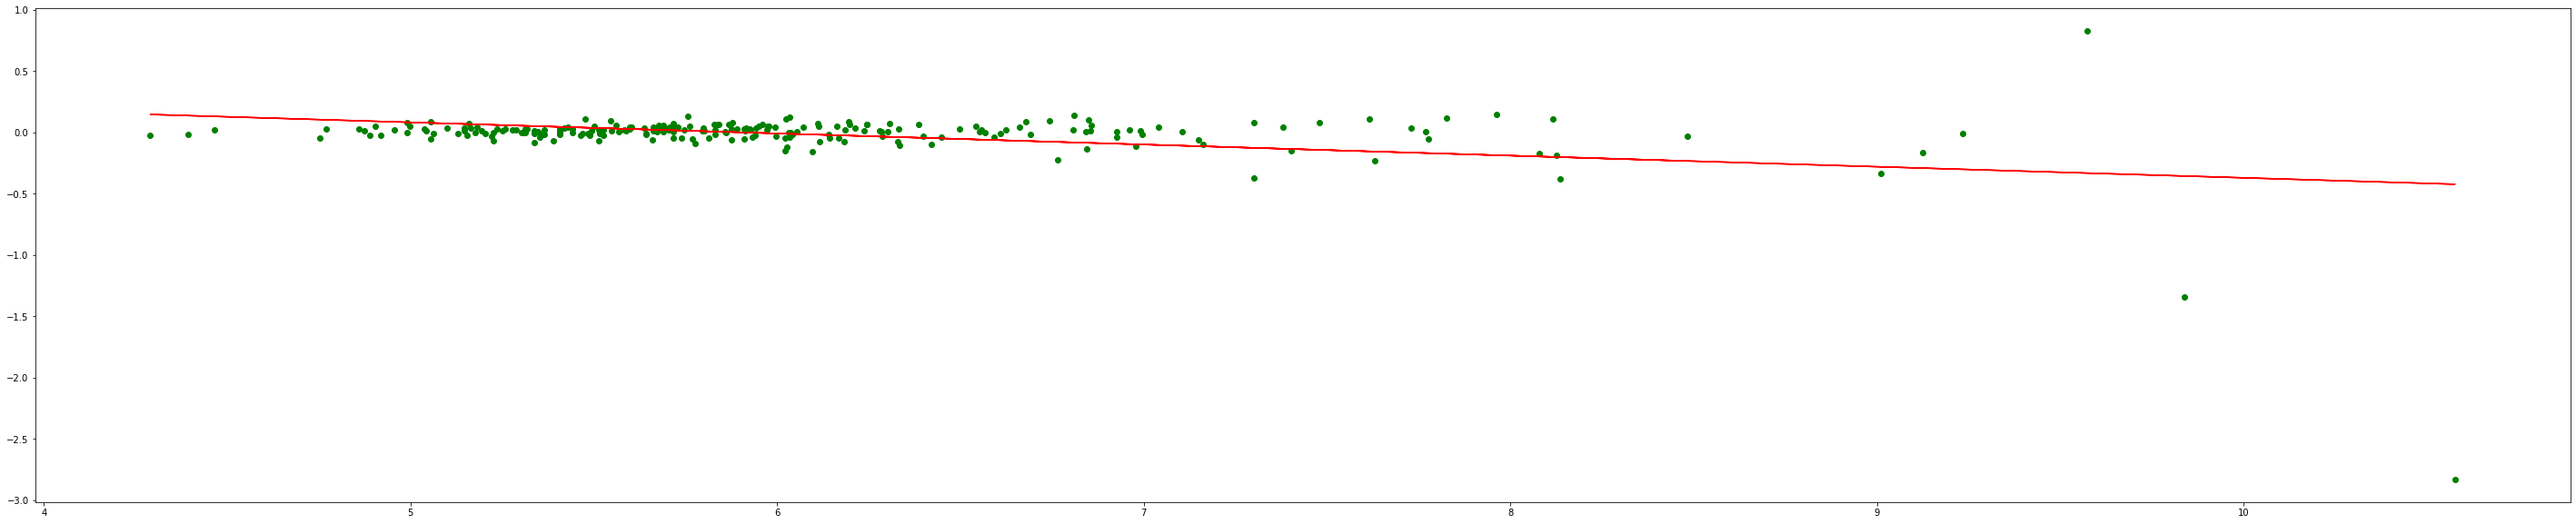

In [603]:
#### This Graph plots the predicted values agains the real values in the time perspektive. 
plt.figure(figsize=(50,10))


plt.scatter(df_week_reg["count_all_tweets"], df_week_reg["returns_week_log"], color="green")

plt.plot(df_week_reg["count_all_tweets"], reg_predictions, color="red")


plt.show()

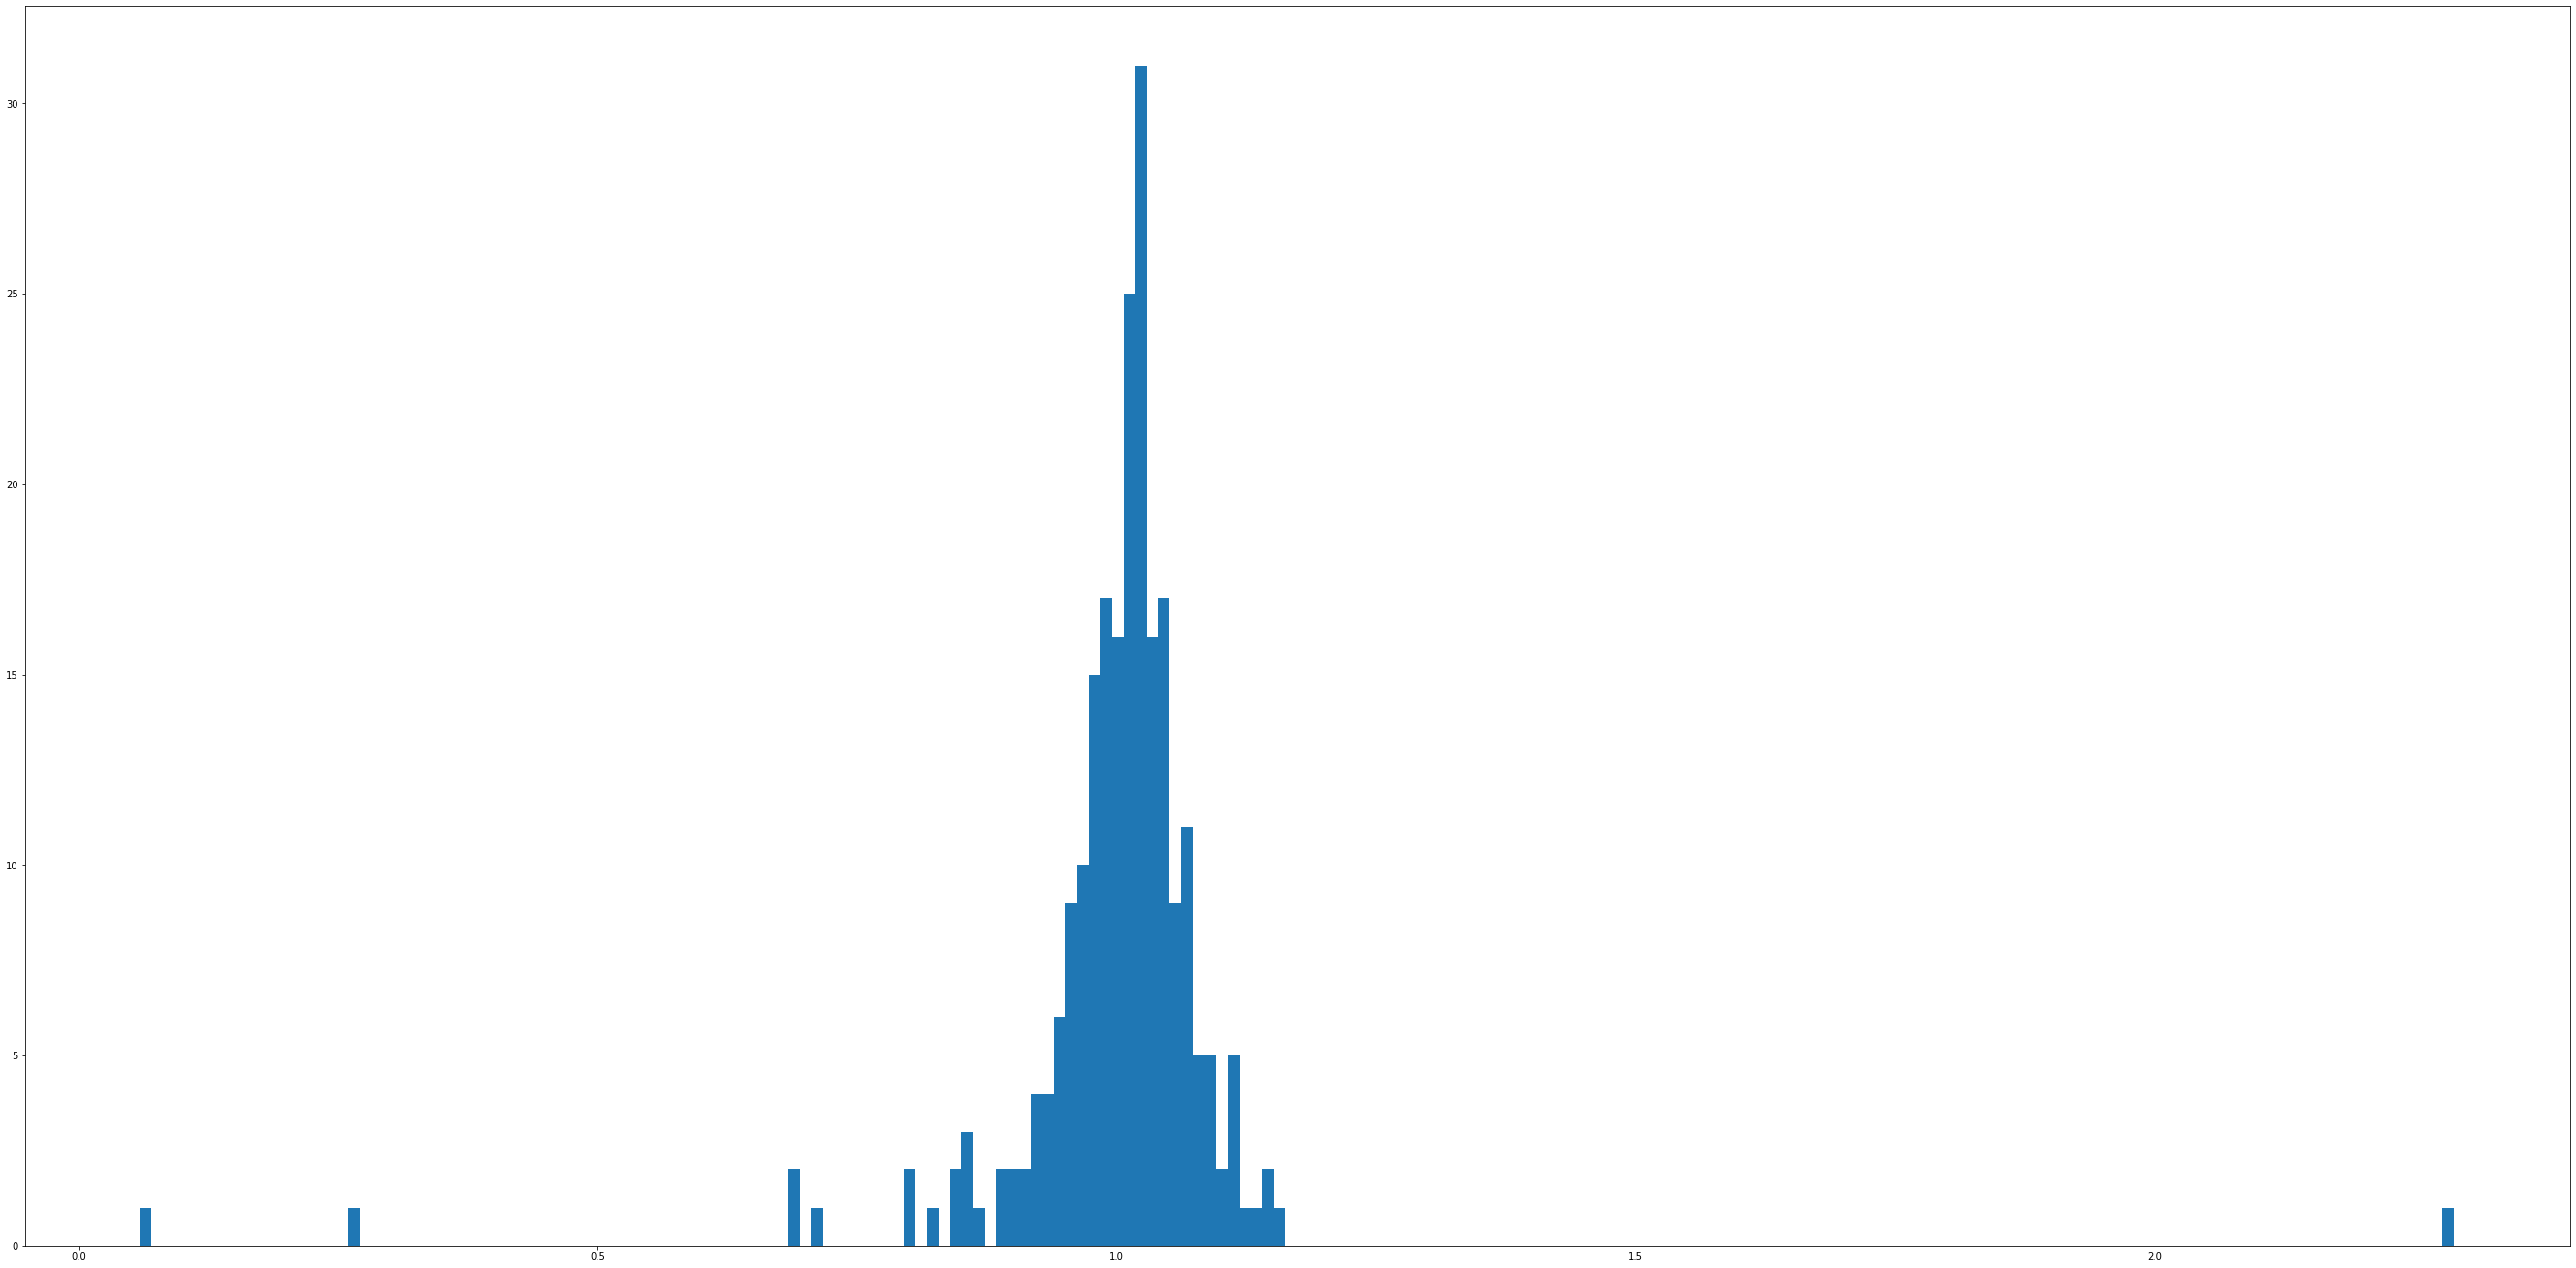

In [469]:
plt.figure(figsize=(50,25))
plt.hist(df_week_reg["returns_week"], bins=200)
#plt.plot(df_week_reg["returns_week"])
plt.show()

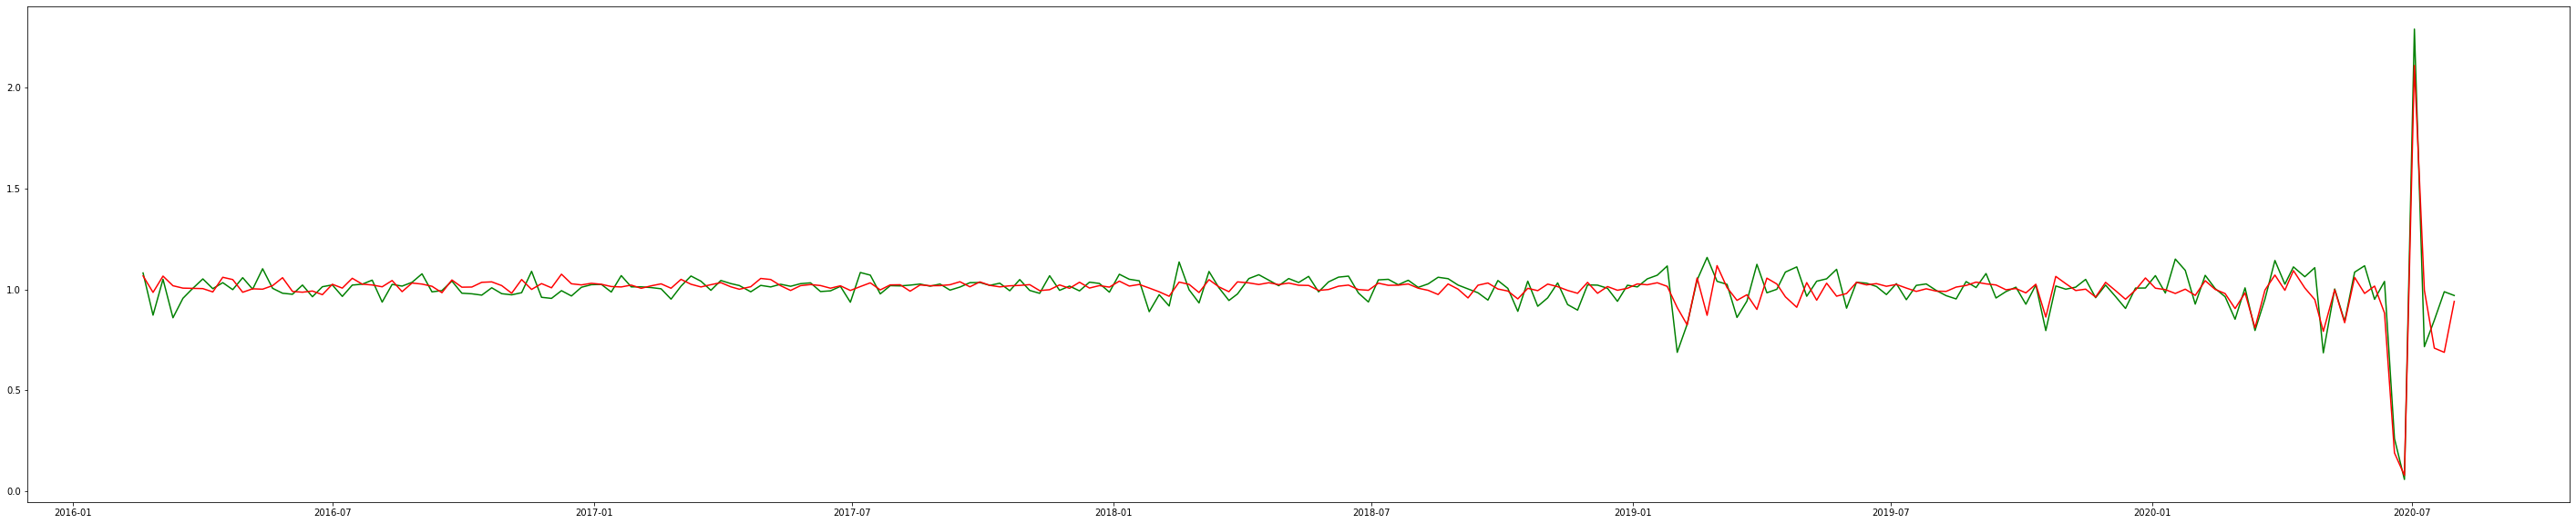

In [218]:
#### This Graph plots the predicted values agains the real values in the time perspektive. 
plt.figure(figsize=(50,10))


plt.plot(df_week_reg["Date"], np.exp(df_week_reg["returns_week_log"]), color="green")
plt.plot(df_week_reg["Date"], np.exp(reg_predictions), color="red")

plt.show()

In [523]:
reg_model, reg_predictions, test, reg_test_y, train, reg_train = regression_train_test(df_week_reg, lagnames, regressand)

                            OLS Regression Results                            
Dep. Variable:       returns_week_log   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     36.02
Date:                Tue, 11 Oct 2022   Prob (F-statistic):           8.02e-09
Time:                        15:30:50   Log-Likelihood:                 297.11
No. Observations:                 221   AIC:                            -590.2
Df Residuals:                     219   BIC:                            -583.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

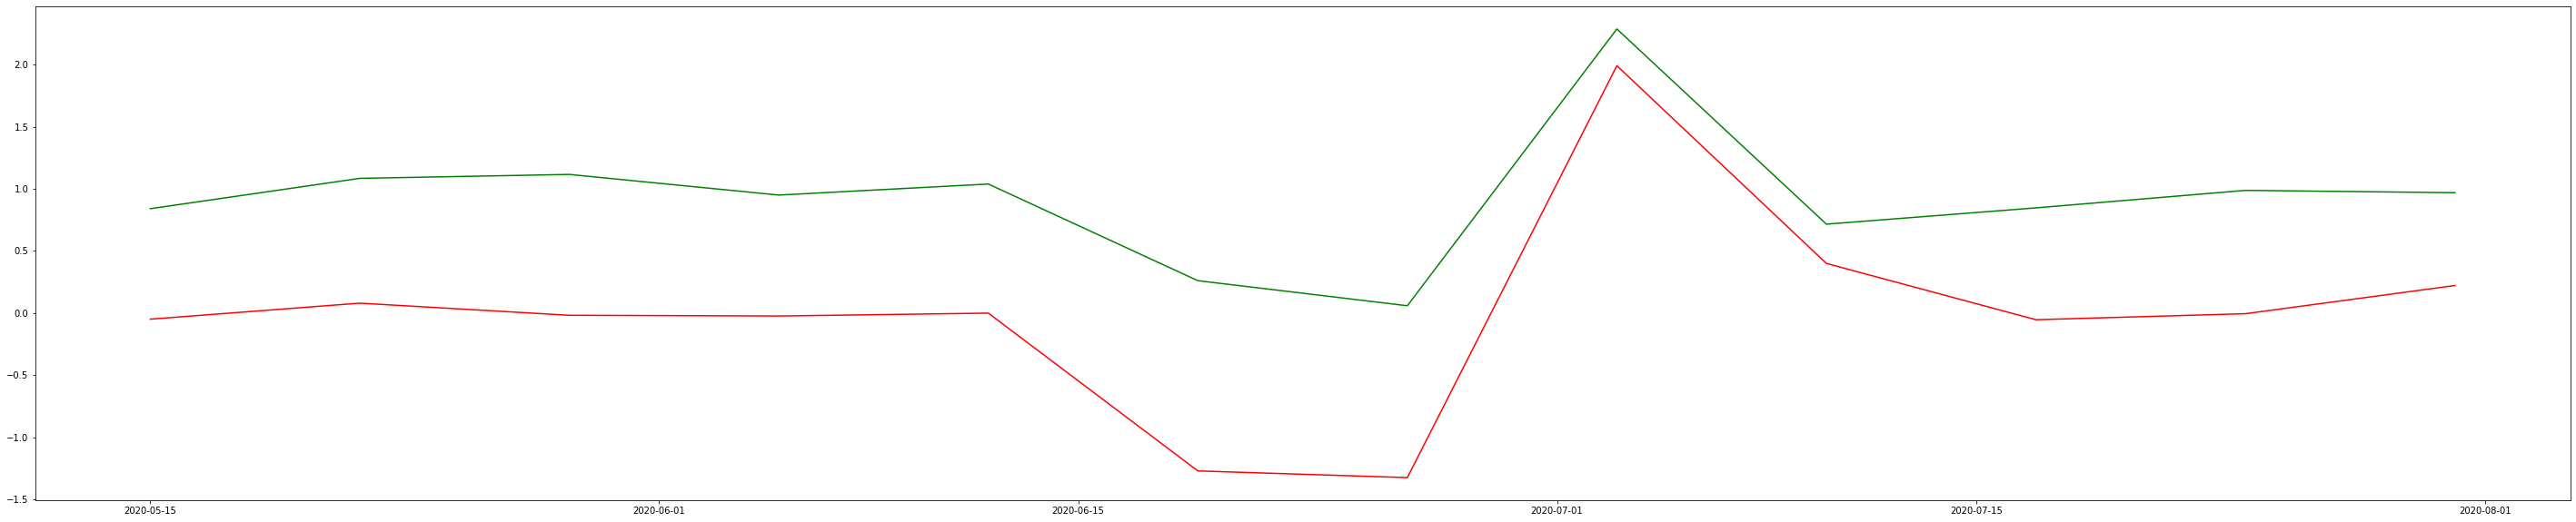

In [524]:
#This Graph plots the predicted values agains the real values in the time perspektive. 
plt.figure(figsize=(50,10))


plt.plot(test["Date"], test["returns_week"], color="green")
plt.plot(test["Date"], reg_predictions, color="red")

plt.show()

In [ ]:
plt.scatter(reg_predictions, test["returns_week"], color="green")
#plt.plot(reg_predictions, test["returns_week"], color="green")

In [ ]:
#This Graph plots the predicted values agains the real values in the time perspektive. 
plt.figure(figsize=(50,10))


plt.plot(train["Date"], train["returns_week"], color="green")
plt.plot(train["Date"], reg_train, color="red")

plt.show()

<h3>Regression Versuch mit mehreren Regressoren</h3>

In [ ]:
#Do a more complex regression
#df_wdi_sentiment["sum_retweet_pos"]
#regressor = ["count_tweets_neg", "count_tweets_pos"]
#regressor = ["pct_pos_sum_all"]


regressor = ["pct_pos", 
            "pct_neg_all", "pct_pos_sum", 
            "pct_pos_sum", "pct_neg_sum_all", "pct_pos_prod"]

#regressor = ["returns_2"]
#regressor = ["count_tweets_pos", "count_tweets_neg"]
#regressor = ["sum_pos_like_retweet", "sum_neg_like_retweet"]
#regressor = ["pct_pos_all", "pct_neg_all"]
#regressor = ["pct_pos_sum", "pct_neg_sum"]
#regressor = ["pct_pos_sum"]
#regressor = ["pct_pos_sum_all", "pct_neg_sum_all"]
#regressor = ["pct_pos_sum_all"]
regressor = ["count_tweets_pos", "count_tweets_neg", "sum_pos_like_retweet", "sum_neg_like_retweet",
             "pct_pos_all", "pct_neg_all", "pct_pos_sum_all", "pct_neg_sum_all"]

regressor = ["dif_pos", "sum_like_pos", "sum_retweet_pos"]
regressor = ["dif_day"]
#regressor = ["dif_day", "sum_like_all", "sum_retweet_all"]

#regressor = ["count_tweets_pos", "count_tweets_neg"]

#regressor = ["return_close"]
#regressor = ["Adj_Close"]
#df_wdi_sentiment["sum_all_like_retweet"]

further_regressors = ["Volume", "count_tweets_all", "returns_5", "stoxx", "visa", "ma"]
#further_regressors = []

output = "returns_5"

lagnames = []

lag_num = 5
train_test = True
log_regressor = False
log_regressand = False

df_wdi_sentiment = create_df(df)
df_wdi_sentiment = add_further_regressors(df_wdi_sentiment)


#####    Further fields    #####
df_wdi_sentiment["stoxx"] = df_stoxx.Adj_Close.pct_change(periods=5) + 1
df_wdi_sentiment["visa"] = df_visa.Adj_Close.pct_change(periods=5) + 1
df_wdi_sentiment["ma"] = df_ma.Adj_Close.pct_change(periods=5) + 1

df_wdi_sentiment["return_close"] = df_wdi_sentiment["returns_2"] * df_wdi_sentiment["pct_pos_sum_all"]

df_wdi_sentiment["dif_day"] = df_wdi_sentiment["sentiment_day"].diff()

df_wdi_sentiment["dif_pos"] = df_wdi_sentiment["count_tweets_pos"].diff()
df_wdi_sentiment["dif_per_pos"] = pct_change_pos_tweets
df_wdi_sentiment["dif_neg"] = df_wdi_sentiment["count_tweets_neg"].diff()

df_wdi_sentiment["dif_pos_sum"] = df_wdi_sentiment["sum_pos_like_retweet"].diff()
df_wdi_sentiment["dif_neg_sum"] = df_wdi_sentiment["sum_neg_like_retweet"].diff()

#####    Add Log    #####
if log_regressand:
    df_wdi_sentiment[output] = np.log(df_wdi_sentiment[output])
if log_regressor:
    for each in regressor:
        df_wdi_sentiment[each] = np.log(df_wdi_sentiment[each]).replace([np.inf, -np.inf], 0)
    for each in further_regressors:
        df_wdi_sentiment[each] = np.log(df_wdi_sentiment[each]).replace([np.inf, -np.inf], 0)


#####    Add Lags to the dataset    ######
lags, df_wdi_sentiment = lagit(df_wdi_sentiment, lag_num, regressor)
#lags, df_wdi_sentiment = lagit(df_wdi_sentiment, lag_num, regressor, True)
lagnames.extend(lags)

lags, df_wdi_sentiment = lagit(df_wdi_sentiment, 1, further_regressors, True)
lagnames.extend(lags)


#####    Execute Regression    #####
if train_test:
    reg_model, reg_predictions, test, reg_test_y, train, reg_train = regression(df_wdi_sentiment, lagnames, output)
else:
    reg_predictions, reg_model = regression_all(df_wdi_sentiment, lagnames, output)

<h2>Outperform</h2>

In [ ]:
test["direction_LR"] = [1 if i > 0 else -1 for i in reg_predictions]

In [ ]:
test["strat_LR"] = test["direction_LR"] * test["returns"]

In [ ]:
np.exp(test[["returns", "strat_LR"]].sum())

In [ ]:
np.exp(test[["returns", "strat_LR"]].cumsum()).plot()

<h2>Test</h2>

<h3>Alte Funktionen</h3>

<h4>Test Funktionen</h4>

In [ ]:
def test(df):
    output = ["returns", "intraday_change", "Adj Close"]
    regressor = ["count_bert_pos", "count_bert_neg", "bert_pos_percent_all", "bert_neg_percent_all", 
       "bert_pos_percent", "bert_neg_percent"]
    
    for each_out in output:
        for each_in in regressor:
            df_wdi_sentiment = create_df(df)
            print("===================================",each_out,": ",each_in,"===============================================\n")
            lagnames, df_wdi_sentiment = lagit(df_wdi_sentiment, 5, each_in)
            reg_model, reg_predictions, test = regression(df_wdi_sentiment, lagnames, each_out)
            print("\n\n\n")
    return df_wdi_sentiment
df_wdi_sentiment = test(df)

<h4>Funktion um unterschiedliche Felder zu berechnen</h4>

In [ ]:
#Create a Support DF to calculate all different values, that might be useful.
def sup_df_for_calculations(df_test, sentiment = "sentiment_bert"):
    
    
    #Create the support df with the conversation id and the date from the df
    df_sup = df_test[["conversation_id", "Date"]].groupby(by=["Date"]).count().reset_index().rename(columns={"conversation_id": "count_tweets_all"})

    #Add Number of POS Tweets to DF
    df_sup = df_sup.merge(df_test.loc[df_test[sentiment] == "POS"][["tweet_id", "Date"]].groupby(by=["Date"]).count().reset_index(), 
                                    how="left",
                                    on="Date").rename(columns={"tweet_id": "count_tweets_pos"}).fillna(0)

    #Add Number of NEG Tweets to DF
    df_sup = df_sup.merge(df_test.loc[df_test[sentiment] == "NEG"][["tweet_id", "Date"]].groupby(by=["Date"]).count().reset_index(), 
                                    how="left",
                                    on="Date").rename(columns={"tweet_id": "count_tweets_neg"}).fillna(0)

    #Add sum of retweet count to DF
    df_sup = df_sup.merge(df_test[["retweet_count", "Date"]].groupby(by=["Date"]).sum().reset_index(), 
                                    how="left",
                                    on="Date").rename(columns={"retweet_count": "sum_retweet_all"}).fillna(0)

    #Add sum of POS retweet count to DF
    df_sup = df_sup.merge(df_test.loc[df_test[sentiment] == "POS"][["retweet_count", "Date"]].groupby(by=["Date"]).sum().reset_index(), 
                                    how="left",
                                    on="Date").rename(columns={"retweet_count": "sum_retweet_pos"}).fillna(0)

    #Add sum of NEG retweet count to DF
    df_sup = df_sup.merge(df_test.loc[df_test[sentiment] == "NEG"][["retweet_count", "Date"]].groupby(by=["Date"]).sum().reset_index(), 
                                    how="left",
                                    on="Date").rename(columns={"retweet_count": "sum_retweet_neg"}).fillna(0)

    #Add sum of liked tweets to DF
    df_sup = df_sup.merge(df_test[["like_count", "Date"]].groupby(by=["Date"]).sum().reset_index(), 
                                    how="left",
                                    on="Date").rename(columns={"like_count": "sum_like_all"}).fillna(0)

    #Add sum of POS liked tweets to DF
    df_sup = df_sup.merge(df_test.loc[df_test[sentiment] == "POS"][["like_count", "Date"]].groupby(by=["Date"]).sum().reset_index(), 
                                    how="left",
                                    on="Date").rename(columns={"like_count": "sum_like_pos"}).fillna(0)

    #Add sum of NEG liked tweets to DF
    df_sup = df_sup.merge(df_test.loc[df_test[sentiment] == "NEG"][["like_count", "Date"]].groupby(by=["Date"]).sum().reset_index(), 
                                    how="left",
                                    on="Date").rename(columns={"like_count": "sum_like_neg"}).fillna(0)

    #Add POS in relation to POS+NEG in percentage
    df_sup["pct_pos"] = df_sup.count_tweets_pos / (df_sup.count_tweets_pos + df_sup.count_tweets_neg)

    #Add NEG in relation to POS+NEG in percentage
    df_sup["pct_neg"] = df_sup.count_tweets_neg / (df_sup.count_tweets_pos + df_sup.count_tweets_neg)

    #Add POS in relation to all tweets in percentage
    df_sup["pct_pos_all"] = df_sup.count_tweets_pos / df_sup.count_tweets_all

    #Add NEG in relation to all tweets in percentage
    df_sup["pct_neg_all"] = df_sup.count_tweets_neg / df_sup.count_tweets_all

    #Add sum of POS tweets, liked and retweets
    df_sup["sum_pos_like_retweet"] = df_sup.count_tweets_pos + df_sup.sum_like_pos + df_sup.sum_retweet_pos

    #Add sum of NEG tweets, liked and retweets
    df_sup["sum_neg_like_retweet"] = df_sup.count_tweets_neg + df_sup.sum_like_neg + df_sup.sum_retweet_neg

    #Add sum of all tweets, liked and retweets
    df_sup["sum_all_like_retweet"] = df_sup.count_tweets_all + df_sup.sum_like_all + df_sup.sum_retweet_all

    #Add pct of POS_sum to NEG_sum and POS_sum
    df_sup["pct_pos_sum"] = df_sup.sum_pos_like_retweet / (df_sup.sum_pos_like_retweet + df_sup.sum_neg_like_retweet)

    #Add pct of NEG_sum to NEG_sum and POS_sum
    df_sup["pct_neg_sum"] = df_sup.sum_neg_like_retweet / (df_sup.sum_pos_like_retweet + df_sup.sum_neg_like_retweet)

    #Add pct of POS_sum to ALL_sum
    df_sup["pct_pos_sum_all"] = df_sup.sum_pos_like_retweet / df_sup.sum_all_like_retweet

    #Add pct of NEG_sum to ALL_sum
    df_sup["pct_neg_sum_all"] = df_sup.sum_neg_like_retweet / df_sup.sum_all_like_retweet

    #Add prod between POS tweets and liked, retweets
    df_sup["prod_pos_like_retweet"] = df_sup.count_tweets_pos * [1 if i == 0 else i for i in (df_sup.sum_like_pos + df_sup.sum_retweet_pos)]

    #Add prod between NEG tweets and liked, retweets
    df_sup["prod_neg_like_retweet"] = df_sup.count_tweets_neg * [1 if i == 0 else i for i in (df_sup.sum_like_neg + df_sup.sum_retweet_neg)]

    #Add prod between all tweets and liked, retweets
    df_sup["prod_all_like_retweet"] = df_sup.count_tweets_all * [1 if i == 0 else i for i in (df_sup.sum_like_all + df_sup.sum_retweet_all)]

    #Add pct of POS_prod to NEG_prod and POS_prod
    df_sup["pct_pos_prod"] = df_sup.prod_pos_like_retweet / (df_sup.prod_pos_like_retweet + df_sup.prod_neg_like_retweet)

    #Add pct of NEG_prod to NEG_prod and POS_prod
    df_sup["pct_neg_prod"] = df_sup.prod_neg_like_retweet / (df_sup.prod_pos_like_retweet + df_sup.prod_neg_like_retweet)

    #Add pct of POS_prod to all_prod
    df_sup["pct_pos_prod_all"] = df_sup.prod_pos_like_retweet / df_sup.prod_all_like_retweet

    #Add pct of NEG_prod to all_prod
    df_sup["pct_neg_prod_all"] = df_sup.prod_neg_like_retweet / df_sup.prod_all_like_retweet
    
    #Add relation of POS and NEG
    df_sup["relation_pos_neg"] = (df_sup["count_tweets_pos"] / df_sup["count_tweets_neg"]).replace(np.inf, np.nan).fillna(0)
    
    #Add relation of NEG and POS
    df_sup["relation_neg_pos"] = (df_sup["count_tweets_neg"] / df_sup["count_tweets_pos"]).replace(np.inf, np.nan).fillna(0)
    
    #Add relation of sum POS and NEG
    df_sup["relation_sum_pos_neg"] = (df_sup["sum_pos_like_retweet"] / df_sup["sum_neg_like_retweet"]).replace(np.inf, np.nan).fillna(0)
    
    #Add relation of sum NEG and POS
    df_sup["relation_sum_neg_pos"] = (df_sup["sum_neg_like_retweet"] / df_sup["sum_pos_like_retweet"]).replace(np.inf, np.nan).fillna(0)
    
    #Add relation of prod POS and NEG
    df_sup["relation_prod_pos_neg"] = (df_sup["prod_pos_like_retweet"] / df_sup["prod_neg_like_retweet"]).replace(np.inf, np.nan).fillna(0)
    
    #Add relation of prod NEG and POS
    df_sup["relation_prod_neg_pos"] = (df_sup["prod_neg_like_retweet"] / df_sup["prod_pos_like_retweet"]).replace(np.inf, np.nan).fillna(0)
    
    #Return the support df
    return df_sup



In [ ]:
def add_further_regressors(df):
    df["sentiment_day"] = df["count_tweets_pos"] - df["count_tweets_neg"]
    df["sentiment_day_sum"] = df["sum_pos_like_retweet"] - df["sum_neg_like_retweet"]
    df["sentiment_day_prod"] = df["prod_pos_like_retweet"] - df["prod_neg_like_retweet"]
    
    df["sentiment_dummy"] = [1 if i > 0 else -1 if i < 0 else 0 for i in df.sentiment_day]
    df["sentiment_dummy_sum"] = [1 if i > 0 else -1 if i < 0 else 0 for i in df.sentiment_day_sum]
    df["sentiment_dummy_prod"] = [1 if i > 0 else -1 if i < 0 else 0 for i in df.sentiment_day_prod]
    
    df["sum_pos_tweets_retweets"] = df["count_tweets_pos"] + df["sum_retweet_pos"]
    df["sum_neg_tweets_retweets"] = df["count_tweets_neg"] + df["sum_retweet_pos"]
    
    df["pos_close"] = df["Adj_Close"] * df["pct_pos_sum"]
    df["pos_returns"] = df["returns"] * df["pct_pos_sum_all"]
    
    df["indicator"] =  [1 if i > 1 else -1 if i < 1 else 0 for i in df["returns_2"]]
    
    return df

<h4>Alte Funktionen für die Regression</h4>

In [ ]:
def test_regression(df, regressor, output, lag_num, train_test = True, log = False, log_2 = False):
    
    print("=========================", regressor, "=========================\n")
    
    df_wdi_sentiment = create_df(df)
    regressor = [regressor]
    
    if log:
        df_wdi_sentiment = log_fkt(df_wdi_sentiment, regressor)
    
    if log_2:
        df_wdi_sentiment = log_fkt(df_wdi_sentiment, output)
    
    df_wdi_sentiment = add_further_regressors(df_wdi_sentiment)
    
    lagnames, df_wdi_sentiment = lagit(df_wdi_sentiment, lag_num, regressor, True)
    
    for each in range(len(lagnames)):
        print("x{each_str}: {lagnames_each}".format(each_str=each+1, lagnames_each=lagnames[each]))
    if train_test:
        reg_model, reg_predictions, test, reg_test_y = regression(df_wdi_sentiment, lagnames, output)
    else:
        reg_predictions, reg_model = regression_all(df_wdi_sentiment, lagnames, output)
        
    return df_wdi_sentiment, lagnames, reg_predictions

<h3>Tests zum löschen</h3>

<h2>Alte Funktionen und alter Code</h2>

In [ ]:
#add data to df
def calculate_sentiment(df):
    #create a DF with the dates (as dates) and the sum of all tweets grouped by the date
    df_date_count = pd.DataFrame({"count_tweets": df["tweet_id"].groupby(pd.to_datetime(df["created_at"]).apply(lambda x: x.date())).count()}).reset_index()
    
    #create a DF with the dates, tweet_id and the sentiment values cahnges to 1, 0 and -1 for calculating the sum grouped by
    #by the date. 
    df_sentiment = pd.DataFrame({"created_at": pd.to_datetime(df["created_at"]).apply(lambda x: x.date()), 
                                 "tweet_id": df["tweet_id"], 
                                 "sentiment_bert": [1 if i == "POS" else 0 if i == "NEU" else -1 for i in df.sentiment_bert]}).reset_index(drop=True)
    
    #Creates a DF for all negativ Values (BERT)
    df_sentiment_neg = df_sentiment.loc[df_sentiment["sentiment_bert"] == -1][["created_at", "tweet_id"]].reset_index(drop=True)

    #Add the information about neg values from bert.
    df_date_count = df_date_count.merge(df_sentiment_neg.groupby(["created_at"]).count().reset_index().rename(columns={"tweet_id": "count_bert_neg"}),
                                        how="outer", on="created_at").fillna(0)
    #Creates a DF for all positiv Values (BERT)
    df_sentiment_pos = df_sentiment.loc[df_sentiment["sentiment_bert"] == 1][["created_at", "tweet_id"]].reset_index(drop=True)

    #Add the information about pos values from bert.
    df_date_count = df_date_count.merge(df_sentiment_pos.groupby(["created_at"]).count().reset_index().rename(columns={"tweet_id": "count_bert_pos"}),
                                        how="outer", on="created_at").fillna(0)
    
    #Calculate pos percent
    df_date_count["bert_pos_percent_all"] = df_date_count["count_bert_pos"] / df_date_count["count_tweets"]
    
    #Calculate neg percent
    df_date_count["bert_neg_percent_all"] = df_date_count["count_bert_neg"] / df_date_count["count_tweets"]
    
    #Calculate pos percent
    df_date_count["bert_pos_percent"] = df_date_count["count_bert_pos"] / (df_date_count["count_bert_pos"] + df_date_count["count_bert_neg"])
    
    #Calculate neg percent
    df_date_count["bert_neg_percent"] = df_date_count["count_bert_neg"] / (df_date_count["count_bert_pos"] + df_date_count["count_bert_neg"])
    
    #Change Date
    df_date_count = df_date_count.rename(columns={"created_at": "Date"})
    
    return df_date_count

In [ ]:
#add data to df 
#In this DF the tweets are not only counted, also the retweet count is used.
def calculate_sentiment(df):    
    #create a DF with the dates, tweet_id and the sentiment values cahnges to 1, 0 and -1 for calculating the sum grouped by
    #by the date. 
    df_sentiment = pd.DataFrame({"created_at": pd.to_datetime(df["created_at"]).apply(lambda x: x.date()), 
                                 "tweet_id": df["tweet_id"], 
                                 "sentiment_bert": [1 if i == "POS" else 0 if i == "NEU" else -1 for i in df.sentiment_bert],
                                 "retweet_count": [1 if i == 0 else i+1 for i in df.retweet_count]}).reset_index(drop=True)
    
    #create a DF with the dates (as dates) and the sum of all tweets grouped by the date
    df_date_count = pd.DataFrame({"count_tweets": df_sentiment["retweet_count"].groupby(pd.to_datetime(df_sentiment["created_at"]).apply(lambda x: x.date())).sum()}).reset_index()
    
    #Creates a DF for all negativ Values (BERT)
    df_sentiment_neg = df_sentiment.loc[df_sentiment["sentiment_bert"] == -1][["created_at", "retweet_count"]].reset_index(drop=True)
                        
    #Add the information about neg values from bert.
    df_date_count = df_date_count.merge(df_sentiment_neg.groupby(["created_at"]).sum().reset_index().rename(columns={"retweet_count": "count_bert_neg"}),
                                        how="outer", on="created_at").fillna(0)
    #Creates a DF for all positiv Values (BERT)
    df_sentiment_pos = df_sentiment.loc[df_sentiment["sentiment_bert"] == 1][["created_at", "retweet_count"]].reset_index(drop=True)

    #Add the information about pos values from bert.
    df_date_count = df_date_count.merge(df_sentiment_pos.groupby(["created_at"]).sum().reset_index().rename(columns={"retweet_count": "count_bert_pos"}),
                                        how="outer", on="created_at").fillna(0)
    
    #Calculate pos percent
    df_date_count["bert_pos_percent_all"] = df_date_count["count_bert_pos"] / df_date_count["count_tweets"]
    
    #Calculate neg percent
    df_date_count["bert_neg_percent_all"] = df_date_count["count_bert_neg"] / df_date_count["count_tweets"]
    
    #Calculate pos percent
    df_date_count["bert_pos_percent"] = df_date_count["count_bert_pos"] / (df_date_count["count_bert_pos"] + df_date_count["count_bert_neg"])
    
    #Calculate neg percent
    df_date_count["bert_neg_percent"] = df_date_count["count_bert_neg"] / (df_date_count["count_bert_pos"] + df_date_count["count_bert_neg"])
    
    #Change Date
    df_date_count = df_date_count.rename(columns={"created_at": "Date"})
    
    return df_date_count

In [ ]:
(df_wdi_sentiment["count_tweets_pos"] / df_wdi_sentiment["count_tweets_neg"]).replace(np.inf, np.nan).fillna(0)

In [ ]:
(df_wdi_sentiment["sum_pos_like_retweet"] / df_wdi_sentiment["sum_neg_like_retweet"]).replace(np.inf, np.nan).fillna(0)

In [ ]:
(df_wdi_sentiment["prod_pos_like_retweet"] / df_wdi_sentiment["prod_neg_like_retweet"]).replace(np.inf, np.nan).fillna(0)

In [ ]:
test_list = []
print(type(test_list))

In [ ]:
if type(test_list) == list:
    print(True)
else:
    print(False)

In [ ]:
df = pd.concat([df_en, df_de]).reset_index(drop=True)

In [ ]:
df_wdi_sentiment["Volume"] = np.log([1 if i == 0 else i for i in df_wdi_sentiment["Volume"]])

In [ ]:
print(len(df_de))
print(len(df_en))
print(len(df_de) + len(df_en))
print(len(df))

In [ ]:
df_wdi_sentiment

In [ ]:
np.log([1 if i == 0 else i for i in df_wdi_sentiment["Volume"]])

In [ ]:
np.log(211)

In [ ]:
np.log([1 if i == 0 else i for i in df_wdi_sentiment["Volume"]])

In [ ]:
df_wdi_sentiment = create_df(df)

In [ ]:
df_wdi_sentiment[df_wdi_sentiment["relation_pos_neg"] < 0]

In [ ]:
[1 if i > 0 else -1 if i < 0 else 0 for i in (df_wdi_sentiment.count_tweets_pos-df_wdi_sentiment.count_tweets_neg)]

In [ ]:
df_wdi_sentiment.tail()

In [ ]:
df_wdi_sentiment.iloc[1139]

In [ ]:
df_wdi_sentiment

In [ ]:
len(create_df(df))

In [ ]:
df["Lag_"+each+"_"+str(i)] = df[each].shift(i)

In [ ]:
df_wdi_sentiment = create_df(df)
df_wdi_sentiment["Adj_Close_prev_day"] = df_wdi_sentiment["Adj_Close"].shift(1)
df_wdi_sentiment.dropna(subset=["Adj_Close_prev_day"], inplace=True)

In [ ]:
df_wdi_sentiment["Adj_Close_prev_day"]

In [ ]:
df_wdi_sentiment

In [ ]:
df_wdi_sentiment["Adj_Close"] + np.sign(df_wdi_sentiment["pct_pos_sum"]) * (df_wdi_sentiment["Adj_Close"] - df_wdi_sentiment["Adj_Close_prev_day"]).

In [ ]:
df_wdi_sentiment["Adj_Close"] + np.sign(df_wdi_sentiment["pct_pos_sum"]) * (df_wdi_sentiment["Adj_Close"] - df_wdi_sentiment["Adj_Close_prev_day"])

<h2>Testy</h2>

In [ ]:
df_X = df_wdi_sentiment[lagnames]

In [ ]:
df_X["returns_2"] = df_wdi_sentiment["returns_2"]

In [ ]:
df_X

In [ ]:
vif = pd.DataFrame()
vif["Features"] = df_X.columns
vif["VIF_Factor"] = [variance_inflation_factor(df_X.values, i) for i in range(df_X.shape[1])]

In [ ]:
vif

In [ ]:
df_stoxx["Adj_Close"]

In [ ]:
df_wdi_sentiment["stoxx"] = df_stoxx.Adj_Close.pct_change() + 1

In [ ]:
#Eingefügt
df["sentiment_bert_value"] = df["sentiment_bert"].replace({"NEU": 0, "NEG": -1, "POS": 1})

In [ ]:
#Added as new function
df_wdi_week = pd.DataFrame(columns=["Date", "Week", "Year", "Adj_Close"])
week = 5
for each in range(len(df_wdi)):
    #Get the date
    each_date = df_wdi["Date"][each]
    adj_close = df_wdi["Adj_Close"][each]
    
    #Check if the date is the last date
    if df_wdi["Date"][each] == datetime.date(2020,7,31):
        #Get Week Number, start and end day
        week = each_date.isocalendar().week
        year = each_date.isocalendar().year
        end_day = df_wdi["Date"].iloc[-1]
        df_wdi_week = df_wdi_week.append({"Date": each_date, "Week": week, "Year": year, "Adj_Close": adj_close}, ignore_index=True)
        print("Week: ", week, "; Ende: ", end_day)
    else:
        #Get the next week number
        next_week = df_wdi["Date"][each+1].isocalendar().week
        
        #Check if the next day is in another week if not get week number and start and end day. 
        if each_date.isocalendar().week != next_week:
            week = each_date.isocalendar().week
            year = each_date.isocalendar().year
            end_day = each_date
            df_wdi_week = df_wdi_week.append({"Date": each_date, "Week": week, "Year": year, "Adj_Close": adj_close}, ignore_index=True)
            print("Week: ", week, "; End: ", end_day)

In [ ]:
#Added to the function
df_wdi_week["returns_week"] = df_wdi_week.Adj_Close.pct_change()+1

In [ ]:
#Added to the pre processing
df_week_year = pd.DataFrame([(i.isocalendar().week, i.isocalendar().year) for i in df["Date"]], columns=["Week", "Year"])
df[["Week", "Year"]] = df_week_year[["Week", "Year"]]

In [ ]:
#Included in funciton
new_row = pd.DataFrame([[datetime.date(2016,2,6), 5, 2016, 40.091812]], columns=["Date", "Week", "Year", "Adj_Close"])
df_wdi_week = pd.concat([df_wdi_week, new_row], ignore_index=True)

In [ ]:
df_test = df_de.copy()

In [ ]:
df_test["sentiment_vader_value"] = [1 if i >= 0.05 else -1 if i <= -0.05 else 0 for i in df_test["sentiment_vader"]]

In [ ]:
df_test["sentiment_vader"].head(10)

In [ ]:
df_test["sentiment_vader_value"].head(10)

In [ ]:
df_en["sentiment_vader"]

In [ ]:
df_de[["Date", "sentiment_bert", "sentiment_bert_value", "sentiment_vader", "sentiment_vader_value", "Week", "Year"]].head(10)

In [ ]:
df_en[["Date", "sentiment_bert", "sentiment_bert_value", "sentiment_vader", "sentiment_vader_value", "Week", "Year"]].head(10)

In [ ]:
df

In [ ]:
print(len(df_de))
print(len(df_en))
print(len(df))

print(len(df_de) + len(df_en))

In [75]:
df_test = pd.DataFrame()

In [76]:
df_test = concat_finance_df(df_wdi)

In [77]:
df_test

,Date,Week,Year,Adj_Close,Volume,returns_week,returns_stoxx,returns_ma,returns_visa
0,2016-02-05,5,2016,42.091812,269.0,NaN,NaN,NaN,NaN
1,2016-02-12,6,2016,39.202427,1286.0,0.931355,0.957203,1.025737,0.984344
2,2016-02-19,7,2016,42.38422,1469.0,1.081163,1.041685,1.022382,1.017767
3,2016-02-26,8,2016,36.972202,5069.0,0.872311,1.020240,1.008987,1.016776
4,2016-03-04,9,2016,38.825764,1623.0,1.050134,1.036936,1.028320,1.016087
...,...,...,...,...,...,...,...,...,...
230,2020-07-03,27,2020,3.25,453745.0,2.288732,1.028154,1.045206,1.033814
231,2020-07-10,28,2020,2.3275,84432.0,0.716154,1.000559,0.979019,0.984055
232,2020-07-17,29,2020,1.9722,61475.0,0.847347,1.021048,1.028341,1.013191
233,2020-07-24,30,2020,1.9492,59495.0,0.988338,0.983744,1.009406,1.000308


In [ ]:
np.log(df_test.Adj_Close).pct_change()

In [79]:
df_test

,Date,Week,Year,Adj_Close,Volume,returns_week,returns_stoxx,returns_ma,returns_visa
0,2016-02-05,5,2016,42.091812,269.0,NaN,NaN,NaN,NaN
1,2016-02-12,6,2016,39.202427,1286.0,0.931355,0.957203,1.025737,0.984344
2,2016-02-19,7,2016,42.38422,1469.0,1.081163,1.041685,1.022382,1.017767
3,2016-02-26,8,2016,36.972202,5069.0,0.872311,1.020240,1.008987,1.016776
4,2016-03-04,9,2016,38.825764,1623.0,1.050134,1.036936,1.028320,1.016087
...,...,...,...,...,...,...,...,...,...
230,2020-07-03,27,2020,3.25,453745.0,2.288732,1.028154,1.045206,1.033814
231,2020-07-10,28,2020,2.3275,84432.0,0.716154,1.000559,0.979019,0.984055
232,2020-07-17,29,2020,1.9722,61475.0,0.847347,1.021048,1.028341,1.013191
233,2020-07-24,30,2020,1.9492,59495.0,0.988338,0.983744,1.009406,1.000308


In [86]:
np.log(np.float64(df_test.Adj_Close))

array([3.73985323, 3.66873866, 3.74677612, 3.61016633, 3.65908405,
       3.50748314, 3.462052  , 3.46065191, 3.51118997, 3.514588  ,
       3.54723515, 3.54580649, 3.60209093, 3.60290149, 3.70010014,
       3.70535476, 3.68603461, 3.66150664, 3.68267394, 3.64548086,
       3.65838424, 3.68019604, 3.64470139, 3.66566543, 3.69105005,
       3.7357014 , 3.67049013, 3.69488933, 3.71083075, 3.7451499 ,
       3.81932511, 3.80691475, 3.8008182 , 3.84113305, 3.82194104,
       3.79970568, 3.77068218, 3.77855762, 3.75695253, 3.72951157,
       3.71289681, 3.79848067, 3.75834558, 3.71265389, 3.70619718,
       3.67289381, 3.68320197, 3.70607486, 3.73046638, 3.71713692,
       3.78309492, 3.79535527, 3.80768812, 3.81659269, 3.81954337,
       3.76987971, 3.78569443, 3.8497461 , 3.88939417, 3.88460009,
       3.92762823, 3.95582624, 3.97450424, 3.96228036, 3.98176757,
       3.99375705, 4.01874472, 4.03383059, 4.06162467, 4.09332519,
       4.08247818, 4.07506823, 4.08981862, 4.02407697, 4.10424

In [85]:
type(np.float64(df_test["Adj_Close"]))

numpy.ndarray

In [83]:
type(df_wdi["Adj_Close"][0])

numpy.float64

In [27]:
np.log(df_wdi.Adj_Close).pct_change()

0            NaN
1      -0.000593
2      -0.007727
3       0.003705
4      -0.018039
          ...   
1136   -0.078262
1137    0.002283
1138    0.164209
1139   -0.085474
1140   -0.030323
Name: Adj_Close, Length: 1141, dtype: float64

In [28]:
np.log(df_stoxx.Adj_Close).pct_change()

0            NaN
1      -0.002890
2      -0.002363
3       0.000375
4      -0.001123
          ...   
1124   -0.000300
1125    0.000027
1126   -0.000127
1127   -0.003488
1128   -0.001315
Name: Adj_Close, Length: 1129, dtype: float64

In [29]:
np.log(df_ma.Adj_Close).pct_change()

0            NaN
1      -0.006959
2       0.001419
3      -0.000367
4      -0.009556
          ...   
1129    0.001102
1130   -0.001437
1131    0.001689
1132   -0.000170
1133   -0.000266
Name: Adj_Close, Length: 1134, dtype: float64

In [30]:
np.log(df_visa.Adj_Close).pct_change()

0            NaN
1      -0.003110
2       0.003120
3      -0.002218
4      -0.006928
          ...   
1129    0.001707
1130   -0.000164
1131    0.001767
1132   -0.004363
1133   -0.003624
Name: Adj_Close, Length: 1134, dtype: float64

In [90]:
df_test = create_finance_df(df_wdi)

AttributeError: 'numpy.ndarray' object has no attribute 'pct_change'

In [48]:
df_test

,Date,Week,Year,Adj_Close,Volume,returns_week
0,2016-02-05,5,2016,42.091812,269.0,NaN
1,2016-02-12,6,2016,39.202427,1286.0,-0.068645
2,2016-02-19,7,2016,42.38422,1469.0,0.081163
3,2016-02-26,8,2016,36.972202,5069.0,-0.127689
4,2016-03-04,9,2016,38.825764,1623.0,0.050134
...,...,...,...,...,...,...
230,2020-07-03,27,2020,3.25,453745.0,1.288732
231,2020-07-10,28,2020,2.3275,84432.0,-0.283846
232,2020-07-17,29,2020,1.9722,61475.0,-0.152653
233,2020-07-24,30,2020,1.9492,59495.0,-0.011662


In [55]:
np.log(df_wdi.Adj_Close.pct_change()+1)

0            NaN
1      -0.002271
2      -0.029548
3       0.014059
4      -0.068702
          ...   
1136   -0.052233
1137    0.001404
1138    0.101250
1139   -0.061357
1140   -0.019906
Name: Adj_Close, Length: 1141, dtype: float64

In [59]:
np.log(df_wdi.Adj_Close).pct_change()

0            NaN
1      -0.000593
2      -0.007727
3       0.003705
4      -0.018039
          ...   
1136   -0.078262
1137    0.002283
1138    0.164209
1139   -0.085474
1140   -0.030323
Name: Adj_Close, Length: 1141, dtype: float64

In [102]:
pd.Series(np.log(np.float64(df_test.Adj_Close))).pct_change()

0           NaN
1     -0.019015
2      0.021271
3     -0.036461
4      0.013550
         ...   
230    2.361277
231   -0.283255
232   -0.196077
233   -0.017273
234   -0.046211
Length: 235, dtype: float64

In [104]:
df_wdi

,Date,Open,High,Low,Close,Adj_Close,Volume,returns,returns_2,returns_3,returns_5
0,2016-02-01,47.090000,47.090000,46.299999,46.299999,45.893112,69,NaN,NaN,NaN,NaN
1,2016-02-02,46.195000,46.195000,46.195000,46.195000,45.789028,0,-0.002270,0.997732,-0.002268,NaN
2,2016-02-03,45.000000,45.000000,44.849998,44.849998,44.455849,90,-0.029548,0.970884,-0.029116,NaN
3,2016-02-04,45.485001,45.485001,45.485001,45.485001,45.085274,0,0.014059,1.014158,0.014158,NaN
4,2016-02-05,43.500000,44.000000,42.465000,42.465000,42.091812,110,-0.068702,0.933604,-0.066396,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1136,2020-07-27,2.228000,2.516000,1.850000,1.850000,1.850000,25093,-0.052233,0.949107,-0.050893,1.178344
1137,2020-07-28,1.847000,1.869200,1.828000,1.852600,1.852600,2035,0.001404,1.001405,0.001405,1.009922
1138,2020-07-29,1.850000,2.092500,1.830000,2.050000,2.050000,19941,0.101250,1.106553,0.106553,1.132597
1139,2020-07-30,2.055000,2.100000,1.928000,1.928000,1.928000,3200,-0.061357,0.940488,-0.059512,1.147346


In [105]:
df_test

,Date,Week,Year,Adj_Close,Volume,returns_week,returns_stoxx,returns_ma,returns_visa
0,2016-02-05,5,2016,42.091812,269.0,NaN,NaN,NaN,NaN
1,2016-02-12,6,2016,39.202427,1286.0,0.931355,0.957203,1.025737,0.984344
2,2016-02-19,7,2016,42.38422,1469.0,1.081163,1.041685,1.022382,1.017767
3,2016-02-26,8,2016,36.972202,5069.0,0.872311,1.020240,1.008987,1.016776
4,2016-03-04,9,2016,38.825764,1623.0,1.050134,1.036936,1.028320,1.016087
...,...,...,...,...,...,...,...,...,...
230,2020-07-03,27,2020,3.25,453745.0,2.288732,1.028154,1.045206,1.033814
231,2020-07-10,28,2020,2.3275,84432.0,0.716154,1.000559,0.979019,0.984055
232,2020-07-17,29,2020,1.9722,61475.0,0.847347,1.021048,1.028341,1.013191
233,2020-07-24,30,2020,1.9492,59495.0,0.988338,0.983744,1.009406,1.000308


In [343]:
df_week_reg.loc[df_week_reg["dif_sentiment_bert_value"] == df_week_reg["dif_sentiment_bert_value"].max()]

,Date,Week,Year,Adj_Close,Volume,returns_week,returns_stoxx,returns_ma,returns_visa,sentiment_bert_value,sentiment_vader_value,count_all_tweets,dif_sentiment_bert_value,dif_sentiment_vader_value,Lag_returns_week,returns_week_log
228,2020-07-03,27,2020,3.25,453745.0,2.288732,1.028154,1.045206,1.033814,-4144,-1351,14374,10833.0,5465.0,0.058921,0.827998


In [350]:
df_week_reg = df_week_reg.drop([228])

In [351]:
df_week_reg["dif_sentiment_bert_value"].min()

-7246.0

In [352]:
df_week_reg.loc[df_week_reg["dif_sentiment_bert_value"] == df_week_reg["dif_sentiment_bert_value"].min()]

,Date,Week,Year,Adj_Close,Volume,returns_week,returns_stoxx,returns_ma,returns_visa,sentiment_bert_value,sentiment_vader_value,count_all_tweets,dif_sentiment_bert_value,dif_sentiment_vader_value,Lag_returns_week,returns_week_log
227,2020-06-26,26,2020,1.42,352175.0,0.058921,0.980138,0.975852,0.984756,-14977,-6816,39201,-7246.0,-5370.0,0.260879,-2.831555


In [353]:
df_week_reg = df_week_reg.drop([227])

In [356]:
df_week_reg["dif_sentiment_bert_value"].min()

-6953.0

In [357]:
df_week_reg.loc[df_week_reg["dif_sentiment_bert_value"] == df_week_reg["dif_sentiment_bert_value"].min()]

,Date,Week,Year,Adj_Close,Volume,returns_week,returns_stoxx,returns_ma,returns_visa,sentiment_bert_value,sentiment_vader_value,count_all_tweets,dif_sentiment_bert_value,dif_sentiment_vader_value,Lag_returns_week,returns_week_log
226,2020-06-19,25,2020,24.1,185717.0,0.260879,1.036579,0.995668,0.999688,-7731,-1446,18720,-6953.0,-1829.0,1.039379,-1.343699


In [358]:
df_week_reg = df_week_reg.drop([226])

In [361]:
df_week_reg["dif_sentiment_bert_value"].min()

-1002.0

In [363]:
df_week_reg.drop([226, 227, 228])

,Date,Week,Year,Adj_Close,Volume,returns_week,returns_stoxx,returns_ma,returns_visa,sentiment_bert_value,sentiment_vader_value,count_all_tweets,dif_sentiment_bert_value,dif_sentiment_vader_value,Lag_returns_week,returns_week_log
0,2016-02-19,7,2016,42.38422,1469.0,1.081163,1.041685,1.022382,1.017767,7,35,147,54.0,33.0,0.931355,0.078037
1,2016-02-26,8,2016,36.972202,5069.0,0.872311,1.020240,1.008987,1.016776,-169,66,938,-176.0,31.0,1.081163,-0.136610
2,2016-03-04,9,2016,38.825764,1623.0,1.050134,1.036936,1.028320,1.016087,-32,22,394,137.0,-44.0,0.872311,0.048918
3,2016-03-11,10,2016,33.364189,1535.0,0.859331,1.012001,0.983676,0.969282,-61,79,412,-29.0,57.0,1.050134,-0.151601
4,2016-03-18,11,2016,31.882332,3759.0,0.955585,0.995436,1.042109,1.030015,-79,-20,311,-18.0,-99.0,0.859331,-0.045431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,2020-06-12,24,2020,92.379997,15769.0,1.039379,0.931876,0.954823,0.963178,-778,383,2273,-27.0,192.0,0.950588,0.038623
229,2020-07-10,28,2020,2.3275,84432.0,0.716154,1.000559,0.979019,0.984055,-1989,-744,8200,2155.0,607.0,2.288732,-0.333860
230,2020-07-17,29,2020,1.9722,61475.0,0.847347,1.021048,1.028341,1.013191,-2305,-1138,9170,-316.0,-394.0,0.716154,-0.165645
231,2020-07-24,30,2020,1.9492,59495.0,0.988338,0.983744,1.009406,1.000308,-2357,-1558,10250,-52.0,-420.0,0.847347,-0.011731


In [504]:
from scipy.stats import levene

stat, p = levene(df_week_reg["returns_week"], df_week_reg["returns_week_log"])

In [505]:
p

0.5542832286479171

In [613]:
from scipy import stats
shapiro_test = stats.shapiro(df_week_reg["sentiment_vader_value"])
print(shapiro_test.pvalue)

6.431008846569018e-30


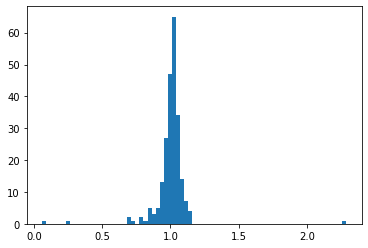

In [536]:
plt.hist(df_week_reg["returns_week"], bins=75)
plt.show()

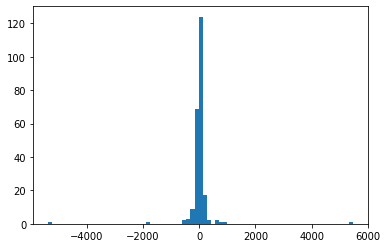

In [609]:
plt.hist(df_week_reg["dif_sentiment_vader_value"], bins=75)
plt.show()

In [605]:
df_week_reg

,Date,Week,Year,Adj_Close,Volume,returns_week,returns_stoxx,returns_ma,returns_visa,sentiment_bert_value,sentiment_vader_value,count_all_tweets,dif_sentiment_bert_value,dif_sentiment_vader_value,Lag_returns_week,returns_week_log
0,2016-02-19,7,2016,42.38422,1469.0,1.081163,1.041685,1.022382,1.017767,7,35,4.990433,54.0,33.0,0.931355,0.078037
1,2016-02-26,8,2016,36.972202,5069.0,0.872311,1.020240,1.008987,1.016776,-169,66,6.843750,-176.0,31.0,1.081163,-0.136610
2,2016-03-04,9,2016,38.825764,1623.0,1.050134,1.036936,1.028320,1.016087,-32,22,5.976351,137.0,-44.0,0.872311,0.048918
3,2016-03-11,10,2016,33.364189,1535.0,0.859331,1.012001,0.983676,0.969282,-61,79,6.021023,-29.0,57.0,1.050134,-0.151601
4,2016-03-18,11,2016,31.882332,3759.0,0.955585,0.995436,1.042109,1.030015,-79,-20,5.739793,-18.0,-99.0,0.859331,-0.045431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,2020-07-03,27,2020,3.25,453745.0,2.288732,1.028154,1.045206,1.033814,-4144,-1351,9.573176,10833.0,5465.0,0.058921,0.827998
229,2020-07-10,28,2020,2.3275,84432.0,0.716154,1.000559,0.979019,0.984055,-1989,-744,9.011889,2155.0,607.0,2.288732,-0.333860
230,2020-07-17,29,2020,1.9722,61475.0,0.847347,1.021048,1.028341,1.013191,-2305,-1138,9.123693,-316.0,-394.0,0.716154,-0.165645
231,2020-07-24,30,2020,1.9492,59495.0,0.988338,0.983744,1.009406,1.000308,-2357,-1558,9.235033,-52.0,-420.0,0.847347,-0.011731


In [552]:
test = [-5, -3, -2, -1, -1, 0, 0, 0, 0, 1, 1, 1, 4]

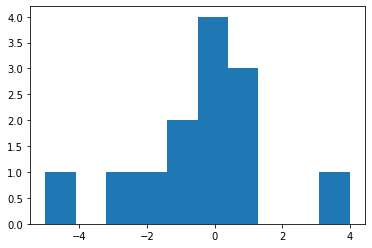

In [553]:
plt.hist(test)
plt.show()

In [554]:
from scipy import stats
shapiro_test = stats.shapiro(test)
print(shapiro_test.pvalue)

0.4652952253818512


In [614]:
df_wdi_2 = pd.read_csv("/Users/tobias/Dev/FOM/Master_Thesis/data/WRCDF_2.csv", parse_dates=["Date"])
df_wdi_2 = df_wdi.rename(columns={"Adj Close": "Adj_Close"})

df_wdi_2["returns"] = np.log(df_wdi_2.Close.pct_change() + 1)
df_wdi_2["returns_2"] = df_wdi_2.Close.pct_change() + 1
df_wdi_2["returns_3"] = df_wdi_2.Close.pct_change()
df_wdi_2["returns_5"] = df_wdi_2.Close.pct_change(periods=5) + 1

df_wdi_2["Date"] = pd.to_datetime(df_wdi_2.Date).apply(lambda x: x.date())

df_test = create_finance_df(df_wdi_2)

In [617]:
df_test = df_test.dropna()

In [618]:
df_test

,Date,Week,Year,Adj_Close,Volume,returns_week
1,2016-02-12,6,2016,39.202427,1286.0,0.931355
2,2016-02-19,7,2016,42.38422,1469.0,1.081163
3,2016-02-26,8,2016,36.972202,5069.0,0.872311
4,2016-03-04,9,2016,38.825764,1623.0,1.050134
5,2016-03-11,10,2016,33.364189,1535.0,0.859331
...,...,...,...,...,...,...
230,2020-07-03,27,2020,3.25,453745.0,2.288732
231,2020-07-10,28,2020,2.3275,84432.0,0.716154
232,2020-07-17,29,2020,1.9722,61475.0,0.847347
233,2020-07-24,30,2020,1.9492,59495.0,0.988338


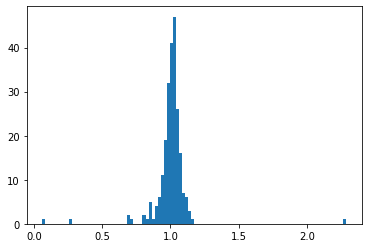

In [622]:
plt.hist(df_test["returns_week"], bins=100)
plt.show()

In [624]:
shapiro_test = stats.shapiro(np.log(df_test["returns_week"]))
print(shapiro_test.pvalue)

7.677887038463634e-29
